In [1]:
import torch
import matplotlib.pyplot as plt
import utils
import numpy as np

from model import Model
from models.model_transformer import *
from torchvision.datasets import Cityscapes


from torch import nn
from torchvision.transforms import v2
from torchvision import transforms
from torch.autograd import Variable

# from helpers import *
# from process_data import *




## Helper functions


In [2]:
class BlendGradient(object):
    def __init__(self,alpha):
        self.alpha = alpha

    def __call__(self,tensor):
        gradients = self.gradient_batch(tensor)
        blended = self.blend_images(tensor,gradients)
        return blended.squeeze(0)



    def gradient_batch(self,batch):
        batch = batch.unsqueeze(0)
        ten=torch.unbind(batch,dim = 1)
        # separate rbg channels
        r = ten[0].unsqueeze(0).permute(1,0,2,3)#
        g = ten[1].unsqueeze(0).permute(1,0,2,3)#.unsqueeze(0)
        b = ten[2].unsqueeze(0).permute(1,0,2,3)#.unsqueeze(0)

        convx =np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
        conv1=nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        conv1.weight=nn.Parameter(torch.from_numpy(convx).float().unsqueeze(0).unsqueeze(0))
        G_x_r=conv1(Variable(r)).data.view(-1,1,r.shape[2],r.shape[3])
        G_x_g=conv1(Variable(g)).data.view(-1,1,g.shape[2],g.shape[3])
        G_x_b=conv1(Variable(b)).data.view(-1,1,b.shape[2],b.shape[3])
        

        convy=np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
        conv2=nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        conv2.weight=nn.Parameter(torch.from_numpy(convy).float().unsqueeze(0).unsqueeze(0))
        G_y_r=conv2(Variable(r)).data.view(-1,1,r.shape[2],r.shape[3])
        G_y_g=conv2(Variable(g)).data.view(-1,1,g.shape[2],g.shape[3])
        G_y_b=conv2(Variable(b)).data.view(-1,1,b.shape[2],b.shape[3])

        G_r = torch.sqrt(torch.pow(G_x_r,2)+ torch.pow(G_y_r,2))
        G_g = torch.sqrt(torch.pow(G_x_g,2)+ torch.pow(G_y_g,2))
        G_b = torch.sqrt(torch.pow(G_x_b,2)+ torch.pow(G_y_b,2))
        return (G_r+G_g+G_b)/3
    

    def blend_images(self,img,edge):
        edge = edge.repeat(1,3,1,1)
        blend = (self.alpha)*img + (1-self.alpha)*edge
        return blend
   

In [3]:
def dice_coefficient(y_true, y_pred, num_classes):
    """
    Function to calculate the Dice Coefficient for each class in a multi-class segmentation task.

    Parameters:
    y_true: numpy.array, true segmentation mask, where each pixel has an integer value representing the class
    y_pred: numpy.array, predicted segmentation mask, with the same dimensions and class representation as y_true
    num_classes: int, number of classes in the segmentation task

    Returns:
    dice_scores: list, Dice Coefficients for each class
    mean_dice_score: float, mean Dice Coefficient over all classes
    """
    
    dice_scores = []
    
    for class_id in range(num_classes):
        # Calculate intersection and union for the current class
        true_class = y_true == class_id
        pred_class = y_pred == class_id
        intersection = np.logical_and(true_class, pred_class)
        union = np.logical_or(true_class, pred_class)
        
        # Calculate Dice score for the current class
        if union.sum() == 0:  # to handle division by zero if there's no ground truth and no prediction for a class
            dice_score = 1.0 if intersection.sum() == 0 else 0.0
        else:
            dice_score = (2. * intersection.sum()) / (true_class.sum() + pred_class.sum())
        
        dice_scores.append(dice_score)
    
    # Calculate mean Dice score across all classes
    mean_dice_score = np.mean(dice_scores)
    
    return dice_scores, mean_dice_score

In [4]:
color_map = {
    0: [128, 64,128],
    1: [244, 35,232],
    2: [ 70, 70, 70],
    3: [102,102,156],
    4: [190,153,153],
    5: [153,153,153],
    6: [250,170, 30],
    7: [220,220,  0],
    8: [107,142, 35],
    9: [152,251,152],
    10:[ 70,130,180],
    11:[220, 20, 60],
    12:[255,  0,  0],
    13:[  0,  0,142],
    14:[  0,  0, 70],
    15:[  0, 60,100],
    16:[  0, 80,100],
    17:[  0,  0,230],
    18:[119, 11, 32]
}

def renormalize_image(image):
    """
    Renormalizes the image to its original range.
    
    Args:
        image (numpy.ndarray): Image tensor to renormalize.
    
    Returns:
        numpy.ndarray: Renormalized image tensor.
    """
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225] 
    renormalized_image = image * std + mean
    return renormalized_image 

def visualize_input_and_target(dataloader, n_samples):
    with torch.no_grad():
        fig, axs = plt.subplots(n_samples, 2, figsize=(12, 4*n_samples))
        if n_samples == 1:
            axs = [axs]

        for i, (images, targets) in enumerate(dataloader):
            if i >= n_samples: 
                break

            images = images.numpy()
            targets = utils.map_id_to_train_id(targets)
            targets = targets.numpy()

            ## Image
            image = renormalize_image(images[0].transpose(1,2,0))

            ## Mask
            target = targets[0]
            _, height, width = target.shape
            rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

            for class_id, color in color_map.items():
                if class_id != 255:
                    rgb_image[target.squeeze() == class_id] = color

            ## Plotting
            axs[i][0].imshow(image)
            axs[i][0].axis('off')
            axs[i][0].set_title(f"Image {i+1}")

            axs[i][1].imshow(rgb_image)
            axs[i][1].axis('off')
            axs[i][1].set_title(f"Mask {i+1}")

            axs[i][1].imshow(rgb_image)
            axs[i][1].axis('off')
            axs[i][1].set_title(f"Mask {i+1}")
        
        plt.tight_layout()
        plt.show()

def visualize_segmentation(model, dataloader, n_samples=5):
    model.to("cpu")
    model.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))
        if n_samples == 1:
            axs = [axs]
            
        for i, (images, targets) in enumerate(dataloader):
            if i >= n_samples:
                break
            
            outputs = model(images)
            outputs = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, 1)

            predicted = predicted[i].numpy()
            print(predicted.shape)
            images = images.numpy()
            targets = utils.map_id_to_train_id(targets)
            targets = targets.numpy()

            ## Image
            image = renormalize_image(images[0].transpose(1,2,0))

            ## Mask
            target = targets[0]
            _, height, width = target.shape
            rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
            pred_image = np.zeros((height, width, 3), dtype=np.uint8)

            for class_id, color in color_map.items():
                if class_id != 255:
                    rgb_image[target.squeeze() == class_id] = color
                    pred_image[predicted.squeeze() == class_id] = color

            ## Plotting
            axs[i][0].imshow(image)
            axs[i][0].axis('off')
            axs[i][0].set_title(f"Image {i+1}")

            axs[i][1].imshow(rgb_image)
            axs[i][1].axis('off')
            axs[i][1].set_title(f"Mask {i+1}")

            axs[i][2].imshow(pred_image)
            axs[i][2].axis('off')
            axs[i][2].set_title(f"Predicted {i+1}")
        
        plt.tight_layout()
        plt.show()

In [5]:
def norm_image(img):
    img_norm = (img-torch.min(img))/(torch.max(img)-torch.min(img))
    return img_norm

In [6]:
resizing_factor = 4
def preprocess(img):
    """preproces image:
    input is a PIL image.
    Output image should be pytorch tensor that is compatible with your model"""
    transforms_train = v2.Compose([v2.Resize((1024//resizing_factor,2048//resizing_factor)),v2.ToImage(),v2.ToDtype(torch.float32,scale = True)])
    img = transforms_train(img)
    img = img.unsqueeze(0)

    return img

def postprocess(prediction, shape):
    """Post process prediction to mask:
    Input is the prediction tensor provided by your model, the original image size.
    Output should be numpy array with size [x,y,n], where x,y are the original size of the image and n is the class label per pixel.
    We expect n to return the training id as class labels. training id 255 will be ignored during evaluation."""
    m = torch.nn.Softmax(dim=1)
    prediction_soft = m(prediction)
    prediction_max = torch.argmax(prediction_soft, axis=1)
    prediction = transforms.functional.resize(prediction_max, size=shape, interpolation=transforms.InterpolationMode.NEAREST)

    prediction_numpy = prediction.cpu().detach().numpy()
    prediction_numpy = prediction_numpy.squeeze()

    return prediction_numpy

# img.size()

In [7]:
# Creating a new transformer that can be used to add noise to the images
class AddGaussianNoise(object):
    '''
    A class to add gaussian noise to a tensor

    ...
    Attribures
    ----------
    std: float, optional
        desired standard deviation for the gaussian noise
    mean: float, optional
        desired mean of the gaussian noise
    
    Methods
    -------
    __call__(self,tensor):
        Returns the tensor with added noise
    '''
    def __init__(self,std = 0.3,mean =0.5):
        '''
        Constructs all the necessary attributes for the AddGaussianNoise object.

        Parameters
        ----------
        std: float, optional
            desired standard deviation for the gaussian noise
        mean: float, optional
            desired mean of the gaussian noise
        ''' 
        self.mean = mean
        self.std = std
        
    def __call__(self,tensor):
        '''
        Returns tensor with added noise

            Params:
                tensor (pytorch tensor): original tensor to add noise to

            Returns:
                tensor+added noise
        '''

        return tensor + torch.randn(tensor.size()) * self.std + self.mean  
    

def norm_image(img):
    img_norm = (img-torch.min(img))/(torch.max(img)-torch.min(img))
    return img_norm


    

def paintbynr(tensor,target,alpha):
    target_norm = norm_image(target)
    target_norm = target_norm.unsqueeze(1)
    target_norm = target_norm.repeat(1,3,1,1)
    batch_size = tensor.shape[0]
    split = batch_size//2
    tensor_no_transform = tensor[:split]
    tensor_to_transform = tensor[split:]
    targets_for_transform = target_norm[split:]

    transformed_tensor =  alpha*tensor_to_transform + (1-alpha)*targets_for_transform
    
    return torch.cat((tensor_no_transform,transformed_tensor),0)

In [8]:
class PaintByNr(object):
    def __init__(self,alpha = 0.1):
        
        self.alpha = alpha

    def __call__(self,tensor,target):
        target_norm = norm_image(target)

        target_norm = target_norm.repeat(1,3,1,1)

        return self.alpha*tensor + (1-self.alpha)*target_norm



    

## Dataloading


In [9]:
batch_size = 5
n_workers = 0
resizing_factor = 4
data_path = './Datasets/CityScapes'
# data loading
transforms_train  = v2.Compose([v2.Resize((1024//resizing_factor,2048//resizing_factor)),v2.ToImage(),v2.ToDtype(torch.float32,scale = True),v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),BlendGradient(1),AddGaussianNoise(mean = 0,std = 0.0)])
target_transforms = v2.Compose([v2.Resize((1024//resizing_factor,2048//resizing_factor)),v2.ToImage()])

dataset = Cityscapes(data_path, split='train', mode='fine', target_type='semantic',transform = transforms_train,target_transform=target_transforms)

indices_train = range(0,int(0.01*len(dataset)))
indices_val = range(int(0.95*len(dataset)),len(dataset))
trainset = torch.utils.data.Subset(dataset,indices_train)
valset = torch.utils.data.Subset(dataset,indices_val)

trainloader = torch.utils.data.DataLoader(trainset,batch_size = batch_size,shuffle = True,num_workers =n_workers)
valloader = torch.utils.data.DataLoader(valset,batch_size =batch_size,shuffle = False,num_workers = n_workers)



## Loading models

In [10]:
# model = VisionTransformer(batch_size=batch_size,num_blocks=3)
model = Model()
# model = Model_Shallow()
model.load_state_dict(torch.load('models/model_baseline3.pth'))
model.eval()
model_robust = Model()
model_robust.load_state_dict(torch.load('models/model_blend5.pth'))
model_robust.eval()
model_paintby = Model()
model_paintby.load_state_dict(torch.load('models/model_paintbynr3.pth'))
model_paintby.eval()

Model(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), st

## Calculating scores


In [11]:
model.cpu()
dice_mean = 0
for batch_idx, (data,target) in enumerate(valloader):
    target_mapped = utils.map_id_to_train_id(target)
    output = model.forward(data)
    output_argmax = torch.argmax(output,dim = 1).unsqueeze(dim = 1)
    a,b = dice_coefficient(output_argmax,target_mapped,19)
    dice_mean += b
# target_mapped.unique()
dice_mean

KeyboardInterrupt: 

In [ ]:
dice_mean/len(valloader)

0.3752470208409553

In [ ]:
dice_mean = 0
for batch_idx, (data,target) in enumerate(valloader):
    target_mapped = utils.map_id_to_train_id(target)
    output = model_robust.forward(data)
    output_argmax = torch.argmax(output,dim = 1).unsqueeze(dim = 1)
    a,b = dice_coefficient(output_argmax,target_mapped,19)
    dice_mean += b
# target_mapped.unique()
dice_mean

8.777513019348445

In [ ]:
dice_mean/len(valloader)

0.29258376731161484

In [ ]:
dice_mean = 0
for batch_idx, (data,target) in enumerate(valloader):
    target_mapped = utils.map_id_to_train_id(target)
    output = model_paintby.forward(data)
    output_argmax = torch.argmax(output,dim = 1).unsqueeze(dim = 1)
    a,b = dice_coefficient(output_argmax,target_mapped,19)
    dice_mean += b
# target_mapped.unique()
dice_mean

11.130284872886381

In [ ]:
dice_mean/len(valloader)

0.3710094957628794

## Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 512)


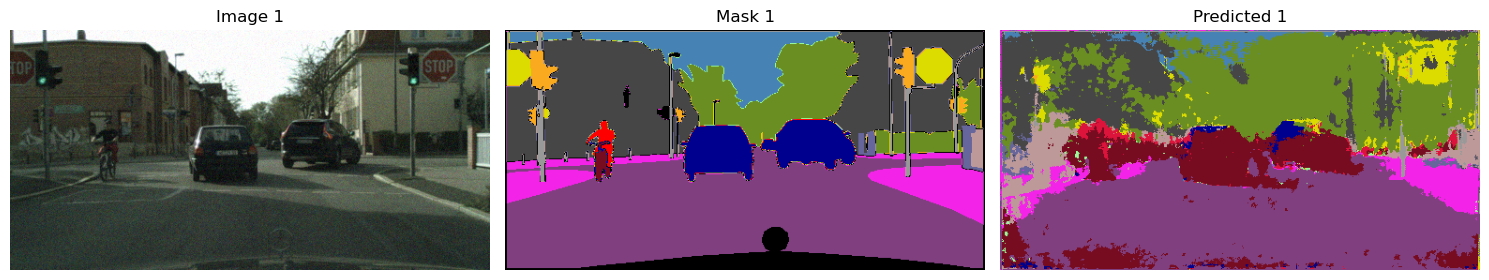

In [ ]:
model.cuda()
visualize_segmentation(model,valloader,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 512)


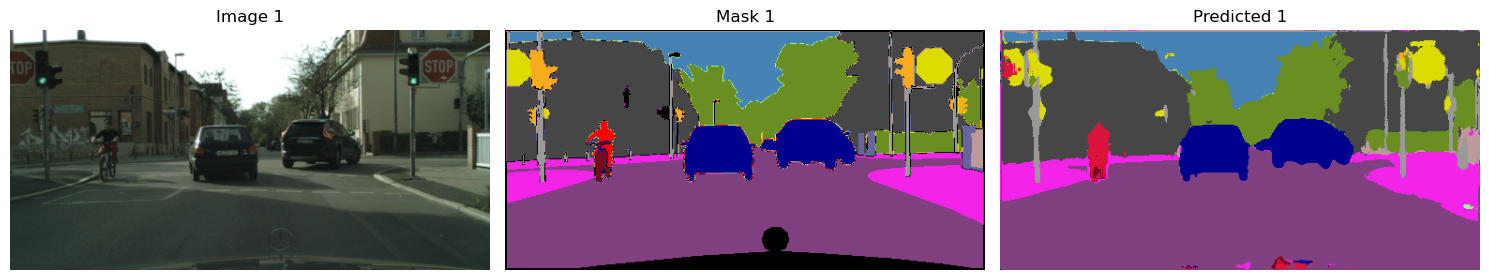

In [ ]:
model_robust.cuda()
visualize_segmentation(model_robust,valloader,1)

In [ ]:
for batch_idx, (data,target) in enumerate(valloader):
    if batch_idx>0:
        break

In [ ]:
painting = PaintByNr(0.1)
painted = painting(data,target)
painted.shape

paint_norm = norm_image(painted)
plt.imshow(paint_norm[3].permute(1,2,0))
plt.title('Input image with painted surfaces')

In [ ]:
blend = BlendGradient(0.6)
print(data[0].shape)
blended = blend(data[0])
blended_norm = norm_image(blended)
blended_norm.shape
plt.imshow(blended_norm.permute(1,2,0))

## Calculating weights for training

In [ ]:
nr_occurences = np.zeros(shape = (19,1))
for batch_idx, (data,target) in enumerate(trainloader):
    target = utils.map_id_to_train_id(target)
    num_classes = 19
    running_nr_occurences = np.zeros(shape = (19,1))
    for class_id in range(num_classes):
        running_nr_occurences[class_id] = torch.sum(target == class_id).float()
    nr_occurences = nr_occurences+running_nr_occurences

In [ ]:
# nr_occurences = nr_occurences
nr_occurences_norm = 1.5-(nr_occurences-np.min(nr_occurences))/(np.max(nr_occurences)-np.min(nr_occurences))/2
nr_occurences_norm_list = [arr.tolist() for arr in nr_occurences_norm]
nr_occurences_norm.tolist()

[[1.0],
 [1.404402248813248],
 [1.0781331349944216],
 [1.4899884059239166],
 [1.4912353159932623],
 [1.4874315840133003],
 [1.4935733817513617],
 [1.4857532868111916],
 [1.3100085314899481],
 [1.48573491129438],
 [1.4638772340472075],
 [1.473966705313587],
 [1.4972309846214424],
 [1.4273379563800233],
 [1.4998525583532036],
 [1.4929586769627896],
 [1.5],
 [1.499532299345919],
 [1.4967221578106884]]